In [4]:
import json
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from joblib import Parallel, delayed
import os
import multiprocessing
import seaborn as sns
import numpy as np


In [5]:

# Carregar dados JSON
with open('./MC3/mc3.json', 'r') as f:
    data = json.load(f)

In [6]:

# Converter dados para DataFrames
df_nodos = pd.DataFrame(data['nodes'])
df_links = pd.DataFrame(data['links'])

In [7]:
df_nodos[df_nodos['id'] == 'Acosta-Flores']

,type,country,ProductServices,PointOfContact,HeadOfOrg,founding_date,revenue,TradeDescription,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,id,dob
14,Entity.Organization.FishingCompany,Mawalara,Fish and seafood products,Katrina Martinez,Alessio Romiti,1961-01-03T00:00:00,24766.67,Acosta-Flores is a leading provider of fresh a...,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,Acosta-Flores,NaN


In [8]:
# Filtrar links de propriedade
#df_links_propriedade = df_links[df_links['type'] == 'Event.Owns.Shareholdership']

In [9]:
#df_links_propriedade[df_links_propriedade['source'] == 'Acosta-Flores']

In [10]:
# Criar grafo
G = nx.from_pandas_edgelist(df_links, 'source', 'target', edge_attr=True)

In [11]:
#missing_nodes = set(df_nodos['id']) - set(G.nodes)
#if missing_nodes:
#    print(f"IDs de nodos ausentes no grafo: {missing_nodes}")

In [12]:
# Adicionar atributos aos nodos
for index, row in df_nodos.iterrows():
    if row['id'] in G.nodes:
        G.nodes[row['id']].update(row.to_dict())

In [13]:
# Visualização inicial do grafo
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
#plt.show()

In [14]:
# Função para calcular o layout em paralelo
def calculate_layout_parallel(graph, num_chunks):
    nodes = list(graph.nodes())
    chunks = [nodes[i::num_chunks] for i in range(num_chunks)]
    
    def spring_layout_chunk(chunk):
        subgraph = graph.subgraph(chunk)
        return nx.spring_layout(subgraph)
    
    layout_parts = Parallel(n_jobs=num_chunks)(
        delayed(spring_layout_chunk)(chunk) for chunk in chunks
    )
    
    pos = {}
    for part in layout_parts:
        pos.update(part)
    
    return pos

In [15]:
num_cores = multiprocessing.cpu_count()
num_cores = int(num_cores * 0.8)

In [16]:
# Calcular o layout usando processamento paralelo
#pos = calculate_layout_parallel(G, num_cores)


In [17]:
# Desenhar o grafo
#nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
#plt.show()

In [18]:
southseafood_node = df_nodos[df_nodos['id'] == 'SouthSeafood Express Corp']
southseafood_node

,type,country,ProductServices,PointOfContact,HeadOfOrg,founding_date,revenue,TradeDescription,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,id,dob
60463,Entity.Organization.FishingCompany,Oceanus,Fishing and other related activities,Luce du Adam,Achille Forza,2032-11-05T00:00:00,6529.36,Offering comprehensive fishing solutions and r...,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,SouthSeafood Express Corp,NaN


In [19]:
southseafood_events = df_links[(df_links['source'] == 'SouthSeafood Express Corp') | (df_links['target'] == 'SouthSeafood Express Corp')]
southseafood_events

,start_date,type,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,source,target,key,end_date
75663,2033-10-29T00:00:00,Event.Owns.Shareholdership,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,AguaLeska Transit N.V.,SouthSeafood Express Corp,0,2035-05-25T00:00:00
75699,2035-05-25T00:00:00,Event.Owns.Shareholdership,Niklaus Oberon,2035-06-15T00:00:00,2035-06-15T00:00:00,Oceanus Corporations Monthly - May '35,Manual Entry,Tainamarine Fishing Co,SouthSeafood Express Corp,0,NaN


Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

In [20]:
df_links['type'].unique()

array(['Event.Owns.Shareholdership', 'Event.Owns.BeneficialOwnership',
       'Event.WorksFor', 'Relationship.FamilyRelationship'], dtype=object)

In [87]:
import pandas as pd
import plotly.express as px

# Função para converter string de data para objeto de data
def convert_to_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%Y-%m-%d").date()
    except ValueError:
        return pd.to_datetime(date_str).date()

# Aplicar a função de conversão de data
df_links['start_date'] = df_links['start_date'].apply(convert_to_date)
df_links['year'] = pd.to_datetime(df_links['start_date']).dt.year



# Contagem de relações por ano, tipo e target
relations_per_year_type_target = df_links.groupby(['year', 'type', 'target']).size().reset_index(name='counts')

# Calcular a média das contagens por ano, tipo e target
average_relations_per_year_type_target = relations_per_year_type_target.groupby(['year', 'type'])['counts'].mean().reset_index(name='average_counts')

# Criação da visualização temporal
fig = px.bar(average_relations_per_year_type_target, x='year', y='average_counts', color='type', 
             title='Média das Mudanças nas Estruturas Corporativas ao Longo do Tempo', barmode='stack')

# Ajustar layout para exibir anos na vertical e sem ordenação automática
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)

fig.show()


In [98]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Event.Owns.Shareholdership']

relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.bar(relations_per_year, x='year', y='counts', color='type', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

In [100]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.bar(relations_per_year, x='year', y='counts', color='type', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

In [101]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Event.WorksFor']

relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.bar(relations_per_year, x='year', y='counts', color='type', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

In [113]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

data_filtered['_date_added'] = data_filtered['_date_added'].apply(convert_to_date)
data_filtered['year_added'] = pd.to_datetime(data_filtered['_date_added']).dt.year

relations_per_year = data_filtered.groupby(['year_added', 'type', 'source']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year_added', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.bar(relations_per_year, x='year_added', y='counts', color='type', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 1}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

/var/folders/rz/cr5j7s253gzd4kgkncpwqkg00000gp/T/ipykernel_37699/257361443.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/cr5j7s253gzd4kgkncpwqkg00000gp/T/ipykernel_37699/257361443.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
data_filtered

,start_date,type,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,source,target,key,end_date,year,year_added
5369,NaN,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Andrew Garcia,Roberta Garcia,0,NaN,NaN,2035
5370,NaN,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Andrew Garcia,Christopher Garcia,0,NaN,NaN,2035
5371,NaN,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Andrew Garcia,Virginia Garcia,0,NaN,NaN,2035
7073,NaN,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Ross Watson MD,Mathew Watson,0,NaN,NaN,2035
9206,NaN,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Dr. Dana Schultz MD,Ms. Dana Jones,0,NaN,NaN,2035
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73589,NaT,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Candice Nunez,Bobby Nunez,0,NaN,NaN,2035
75718,NaT,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Lena Conti-Park,Nathan Conti,0,NaN,NaN,2035
75719,NaT,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Lena Conti-Park,Fintan Park,0,NaN,NaN,2035
75726,NaT,Relationship.FamilyRelationship,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01,Existing Corporate Structure Data,Automatic Import,Nadia Conti,Liam Conti,0,NaN,NaN,2035


In [118]:
data_filtered[['source', 'target']]

,source,target
5369,Andrew Garcia,Roberta Garcia
5370,Andrew Garcia,Christopher Garcia
5371,Andrew Garcia,Virginia Garcia
7073,Ross Watson MD,Mathew Watson
9206,Dr. Dana Schultz MD,Ms. Dana Jones
...,...,...
73589,Candice Nunez,Bobby Nunez
75718,Lena Conti-Park,Nathan Conti
75719,Lena Conti-Park,Fintan Park
75726,Nadia Conti,Liam Conti


Exemplos de Transações Comerciais Típicas e Atípicas
Para identificar e visualizar transações típicas e atípicas, vamos criar gráficos que mostrem a distribuição dos tipos de transações:

In [22]:
# Exemplo de transações típicas e atípicas
transaction_counts = df_links['type'].value_counts().reset_index()
transaction_counts.columns = ['TransactionType', 'Counts']

# Gráfico de pizza para mostrar a distribuição dos tipos de transações
fig = px.pie(transaction_counts, values='Counts', names='TransactionType', title='Distribuição dos Tipos de Transações')
fig.show()


Inferências de Influência ao Longo do Tempo
Para inferir a influência de uma empresa ao longo do tempo, utilizaremos métricas de centralidade:

In [23]:
# Calcular centralidade ao longo do tempo
centrality = nx.degree_centrality(G)

# Converter para DataFrame para visualização
df_centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['Centrality'])
df_centrality.reset_index(inplace=True)
df_centrality.columns = ['Node', 'Centrality']

# Visualização da centralidade
fig = px.histogram(df_centrality, x='Centrality', title='Distribuição da Centralidade das Empresas')
fig.show()


Rede Associada à SouthSeafood Express Corp e Impactos
Identificar a rede associada à SouthSeafood Express Corp e visualizar mudanças após o comportamento ilegal:

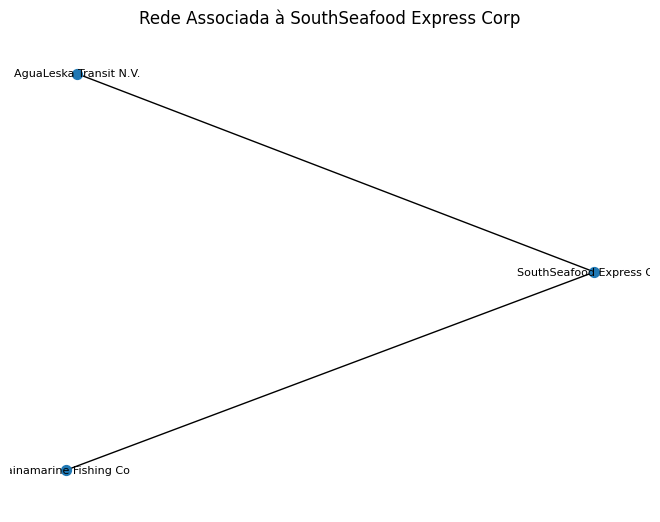

In [24]:
# Filtrar as arestas e nós relacionados à SouthSeafood Express Corp
ssc_network = df_links[(df_links['source'] == 'SouthSeafood Express Corp') | (df_links['target'] == 'SouthSeafood Express Corp')]

# Criar subgrafo
ssc_subgraph = G.subgraph(ssc_network['source'].tolist() + ssc_network['target'].tolist())

# Visualização do subgrafo
pos = nx.kamada_kawai_layout(ssc_subgraph)
nx.draw(ssc_subgraph, pos, with_labels=True, node_size=50, font_size=8)
plt.title('Rede Associada à SouthSeafood Express Corp')
plt.show()


#refazendo primeiro item    

Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

In [25]:
df_links_property = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficial = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

In [26]:
# Criar um grafo direcionado para relações de propriedade
G_property = nx.DiGraph()
for _, row in df_links_property.iterrows():
    G_property.add_edge(row['source'], row['target'], start_date=row['start_date'], end_date=row['end_date'])

# Criar um grafo direcionado para relações de benefício econômico
G_beneficial = nx.DiGraph()
for _, row in df_links_beneficial.iterrows():
    G_beneficial.add_edge(row['source'], row['target'], start_date=row['start_date'], end_date=row['end_date'])


In [27]:
df_links_property = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficial = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

In [28]:
# Função para plotar grafo com base nas datas
def plot_temporal_graph(G, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    for u, v, data in edges:
        plt.plot([data['start_date'], data['end_date']], [pos[u][1], pos[v][1]], linewidth=2, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(title)
    plt.xlabel('Tempo')
    plt.ylabel('Empresas')
    plt.grid(True)
    plt.show()

# Plotar evolução temporal das relações de propriedade
#plot_temporal_graph(G_property, 'Evolução Temporal das Relações de Propriedade')


/var/folders/rz/cr5j7s253gzd4kgkncpwqkg00000gp/T/ipykernel_37699/1844283938.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/cr5j7s253gzd4kgkncpwqkg00000gp/T/ipykernel_37699/1844283938.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/cr5j7s253gzd4kgkncpwqkg00000gp/T/ipykernel_37699/1844283938.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

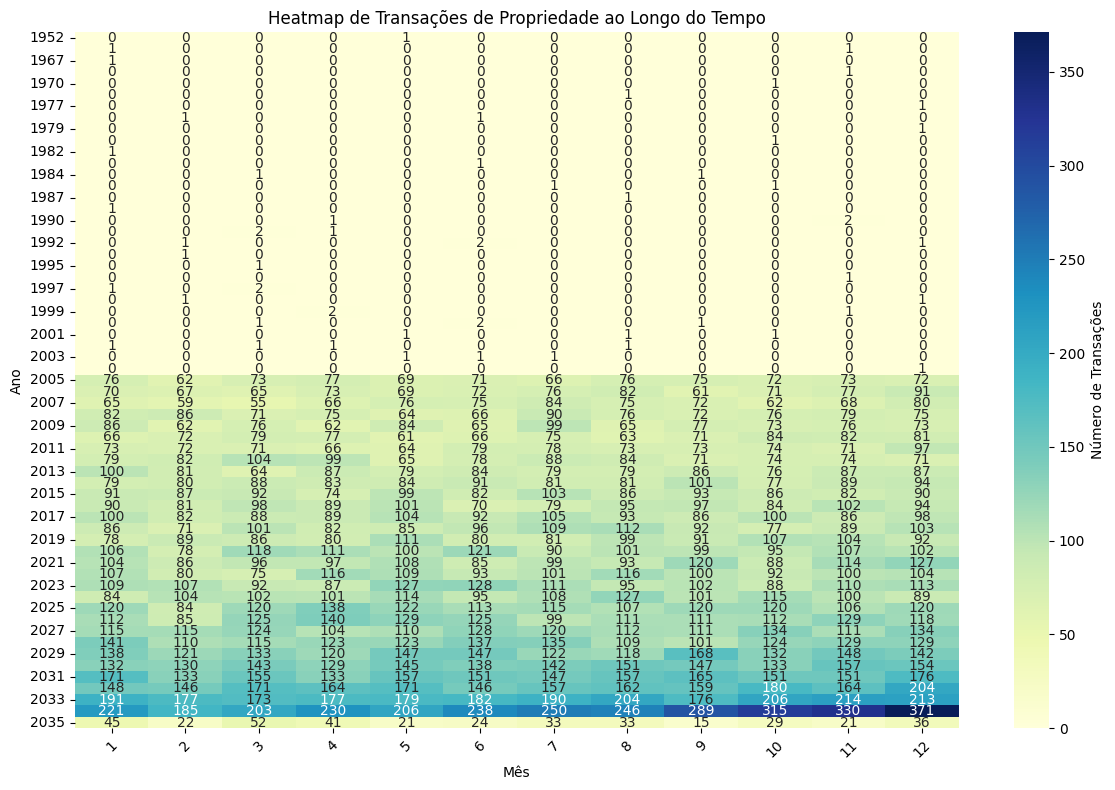

In [29]:
# Converter coluna de data para tipo datetime
df_links_property['start_date'] = pd.to_datetime(df_links_property['start_date'])

# Agrupar por ano e contar o número de transações de propriedade
df_links_property['year'] = df_links_property['start_date'].dt.year
df_links_property['month'] = df_links_property['start_date'].dt.month

heatmap_data = df_links_property.groupby(['year', 'month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Número de Transações'})
plt.title('Heatmap de Transações de Propriedade ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Ano')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Empresas adquirentes

In [30]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_targets(df): #empresas adquirentes
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df): #empresas com adquiridas
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership_adquirentes = count_unique_targets(df_links_shareholdership)
count_beneficialownership_adquirentes = count_unique_targets(df_links_beneficialownership)
count_works = count_unique_sources(df_links_worksfor)
count_familyrelationship = count_unique_targets(df_links_familyrelationship)

In [31]:
max_shareholder_year = count_shareholdership_adquirentes.groupby('start_date')['count'].max().reset_index()
max_beneficialownership_year = count_beneficialownership_adquirentes.groupby('start_date')['count'].max().reset_index()
max_count_worksfor_year = count_works.groupby('start_date')['count'].max().reset_index()

In [32]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_source(df): #empresas adquirentes
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

def count_unique_targets(df): #empresas adquiridas
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df): #empresas com funcionarios
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership_adquirentes = count_unique_source(df_links_shareholdership)
count_beneficialownership_adquirentes = count_unique_source(df_links_beneficialownership)

count_shareholdership_adquiridas = count_unique_targets(df_links_shareholdership)
count_beneficialownership_adquiridas = count_unique_targets(df_links_beneficialownership)


count_works = count_unique_source(df_links_worksfor)
#count_familyrelationship = count_unique_source(df_links_familyrelationship)

In [33]:
max_shareholder_year_adquirentes = count_shareholdership_adquirentes.groupby('start_date')['count'].max().reset_index()
#max_beneficialownership_year = count_beneficialownership_adquirentes.groupby('start_date')['count'].max().reset_index()
#max_count_worksfor_year = count_works.groupby('start_date')['count'].max().reset_index()

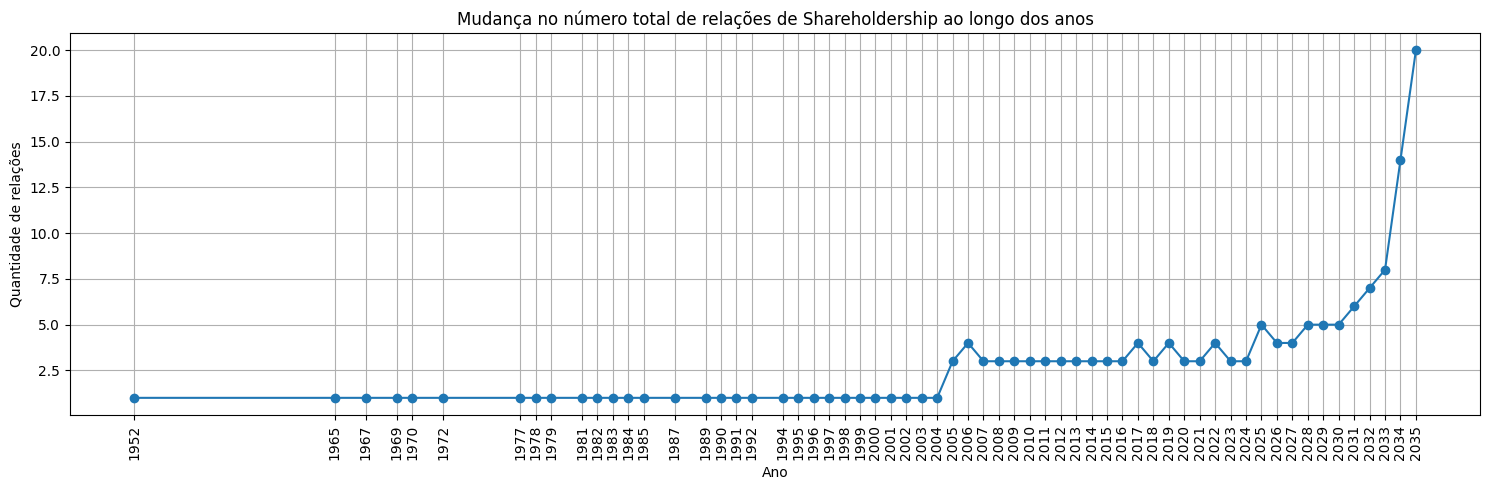

In [34]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_shareholder_year_adquirentes['start_date'], max_shareholder_year_adquirentes['count'], marker='o')
plt.title('Mudança no número total de relações de Shareholdership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_shareholder_year_adquirentes['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
media_shareholder = max_shareholder_year['count'].mean()
media_shareholder = 4

In [36]:
count_shareholdership_adquirentes[count_shareholdership_adquirentes['count'] > media_shareholder]

,target,start_date,count
297,Allen Inc,2034,7
399,"Allen, Villa and Allen",2034,5
400,Allen-Beltran,2034,8
427,Allen-Taylor,2034,5
1337,"Banks, Gray and Gonzales",2032,6
...,...,...,...
33108,"Zhang, Cunningham and Kline",2034,5
33115,"Zimmerman, Garrison and Frazier",2033,5
33116,"Zimmerman, Garrison and Frazier",2034,9
33125,Čechová Kašpar s.r.o.,2035,9


In [37]:
df = count_shareholdership_adquirentes[count_shareholdership_adquirentes['count'] > media_shareholder]
df = df.groupby(['count', 'start_date']).size().reset_index(name='num_companies').sort_values(by='start_date')
df = df.rename(columns={'count': 'count_shareholdership_adquirentes'})
#df.sort_values(by='count_shareholdership_adquirentes', ascending=False)

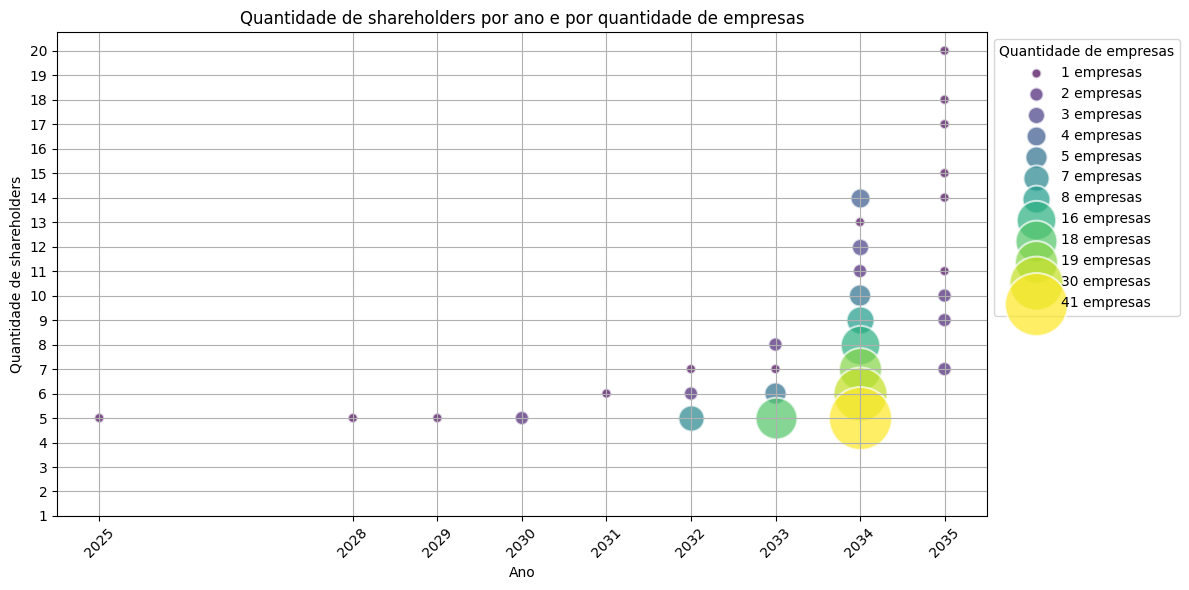

In [38]:
num_companies_unique = sorted(df['num_companies'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(num_companies_unique)))

# Mapeando as cores para cada valor único de num_companies
color_map = {num_companies: colors[i] for i, num_companies in enumerate(num_companies_unique)}

# Convertendo num_companies para cores correspondentes
df['color'] = df['num_companies'].map(color_map)

# Preparando o gráfico de dispersão
plt.figure(figsize=(12, 6))
for num_companies in num_companies_unique:
    df_filtered = df[df['num_companies'] == num_companies]
    plt.scatter(df_filtered['start_date'], df_filtered['count_shareholdership_adquirentes'], s=df_filtered['num_companies']*50, c=[color_map[num_companies]], label=f'{num_companies} empresas', alpha=0.7, edgecolors='w', linewidth=1.5)

# Adicionando título e rótulos dos eixos
plt.title('Quantidade de shareholders por ano e por quantidade de empresas')
plt.xlabel('Ano')
plt.ylabel('Quantidade de shareholders')

# Adicionando a legenda
plt.legend(title='Quantidade de empresas', loc='upper left', bbox_to_anchor=(1, 1))

# Configurando os ticks para mostrar todos os valores
plt.xticks(df['start_date'].unique(), rotation=45)
plt.yticks(np.arange(1, df['count_shareholdership_adquirentes'].max() + 1))

plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
lista_empresas = count_shareholdership_adquirentes[(count_shareholdership_adquirentes['count'] > media_shareholder)  & (count_shareholdership_adquirentes['start_date'] == 2035)][['target', 'count']]
#lista_empresas
lista_empresas_adq = df_nodos[df_nodos['id'].isin(lista_empresas['target'])][['id', 'type']]
merged_df = lista_empresas_adq.merge(lista_empresas, left_on='id', right_on='target', how='inner')
merged_df = merged_df[['target', 'type', 'count']].sort_values(by='count', ascending=False)
merged_df = merged_df.rename(columns={'count': 'count_shareholdership_adquirentes'})
merged_df

,target,type,count_shareholdership_adquirentes
0,Tomanová Musil s.r.o.,Entity.Organization.Company,20
11,Hájková Burešová a.s.,Entity.Organization.Company,18
6,Němec Janečková s.r.o.,Entity.Organization.Company,17
8,Mareš Jelínková k.s.,Entity.Organization.Company,15
10,Šťastná Strnad v.o.s.,Entity.Organization.Company,14
3,Mašková Marková s.r.o.,Entity.Organization.Company,11
7,Polák Procházka a.s.,Entity.Organization.Company,10
9,Bílek a.s.,Entity.Organization.Company,10
4,Pospíšilová Valentová s.r.o.,Entity.Organization.Company,9
5,Čechová Kašpar s.r.o.,Entity.Organization.Company,9


In [40]:
lista_aquisicoes = df_links_shareholdership[(df_links_shareholdership['target'].isin(lista_empresas['target'])) & (df_links_shareholdership['year'] == 2035)][['source', 'target']]
filtered_nodos = df_nodos[df_nodos['id'].isin(lista_aquisicoes['source'])][['id', 'type']]
merged_df = lista_aquisicoes.merge(filtered_nodos, left_on='source', right_on='id', how='inner')
merged_df = merged_df[['source', 'type', 'target']]
merged_df[merged_df['target'] == 'Polák Procházka a.s.']
#merged_df

,source,type,target
6,Joel Richards,Entity.Person,Polák Procházka a.s.
72,Jessica Gentry,Entity.Person,Polák Procházka a.s.
106,Carrie Hester,Entity.Person,Polák Procházka a.s.
107,Kaylee Marshall,Entity.Person,Polák Procházka a.s.
108,Linda Murray,Entity.Person,Polák Procházka a.s.
109,Dawn Sanders,Entity.Person,Polák Procházka a.s.
110,Shawn Perkins,Entity.Person,Polák Procházka a.s.
111,Heidi Peters,Entity.Person,Polák Procházka a.s.
112,Lawrence Lopez,Entity.Person,Polák Procházka a.s.
113,Tyler Le,Entity.Person,Polák Procházka a.s.


# Empresas adquiridas


In [41]:
max_shareholder_year_adquiridas = count_shareholdership_adquiridas.groupby('start_date')['count'].max().reset_index()

In [42]:
max_shareholder_year_adquiridas

,start_date,count
0,1952,1
1,1965,1
2,1967,1
3,1969,1
4,1970,1
...,...,...
56,2031,2
57,2032,2
58,2033,2
59,2034,2


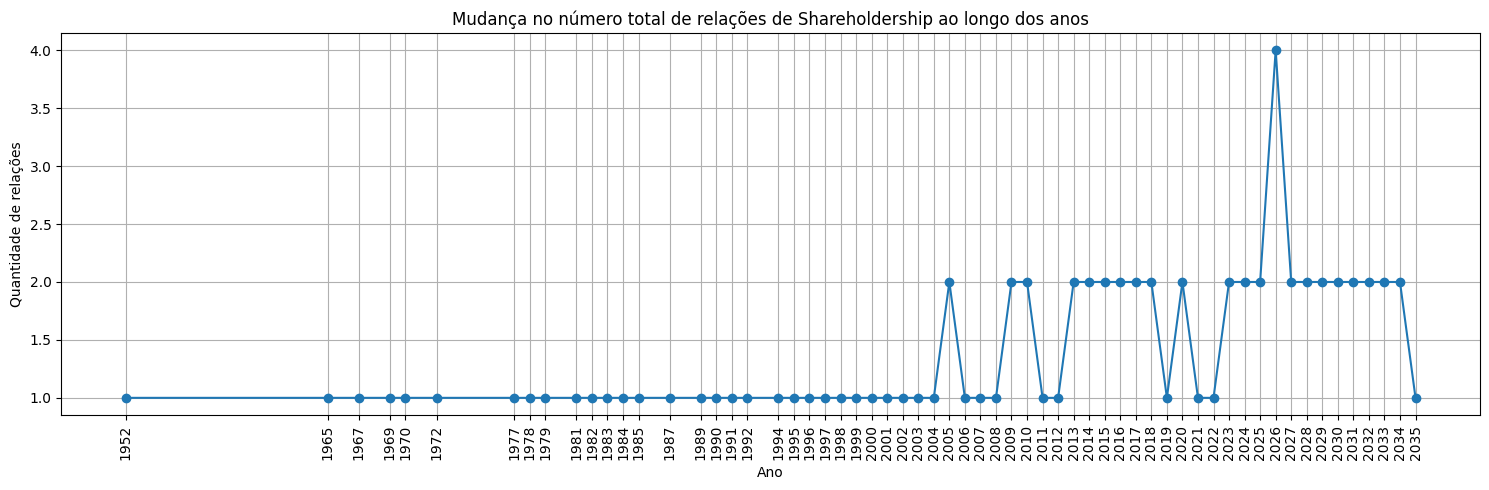

In [43]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_shareholder_year_adquiridas['start_date'], max_shareholder_year_adquiridas['count'], marker='o')
plt.title('Mudança no número total de relações de Shareholdership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_shareholder_year_adquiridas['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
df = count_shareholdership_adquiridas[count_shareholdership_adquiridas['count'] > 1].groupby(['count', 'start_date']).size().reset_index(name='num_companies').sort_values(by='start_date')


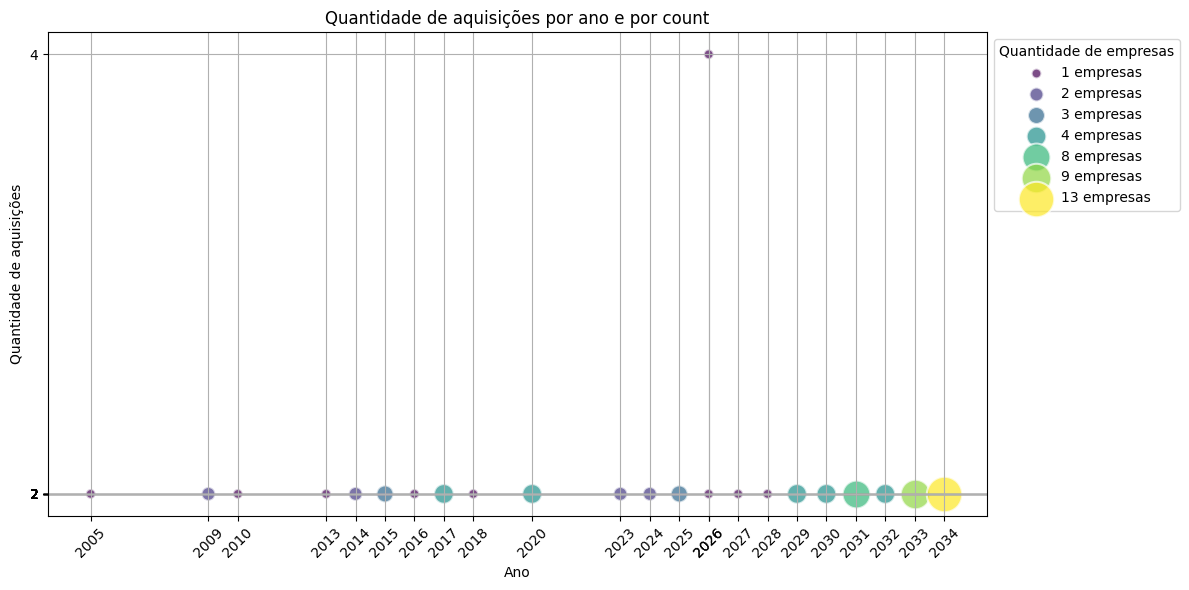

In [45]:

# Determinando as cores com base na quantidade de empresas (num_companies)
num_companies_unique = sorted(df['num_companies'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(num_companies_unique)))

# Mapeando as cores para cada valor único de num_companies
color_map = {num_companies: colors[i] for i, num_companies in enumerate(num_companies_unique)}

# Convertendo num_companies para cores correspondentes
df['color'] = df['num_companies'].map(color_map)

# Preparando o gráfico de dispersão
plt.figure(figsize=(12, 6))
for i, num_companies in enumerate(num_companies_unique):
    df_filtered = df[df['num_companies'] == num_companies]
    plt.scatter(df_filtered['start_date'], df_filtered['count'], s=df_filtered['num_companies']*50, c=[color_map[num_companies]], label=f'{num_companies} empresas', alpha=0.7, edgecolors='w', linewidth=1.5)

# Adicionando título e rótulos dos eixos
plt.title('Quantidade de aquisições por ano e por count')
plt.xlabel('Ano')
plt.ylabel('Quantidade de aquisições')

# Adicionando a legenda
plt.legend(title='Quantidade de empresas', loc='upper left', bbox_to_anchor=(1, 1))

# Configurando os ticks para mostrar todos os valores
plt.xticks(df['start_date'], rotation=45)
plt.yticks(df['count'])

plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
lista_proprietarios = count_shareholdership_adquiridas[(count_shareholdership_adquiridas['count'] > 1)  & (count_shareholdership_adquiridas['start_date'] == 2034)]['source']
df_nodos[df_nodos['id'].isin(lista_proprietarios)][['id', 'type']]

,id,type
3028,Hamilton-Park,Entity.Organization.Company
23506,Xavier Guillaume,Entity.Person.CEO
26452,David Copeland,Entity.Person
30923,Paige Palmer,Entity.Person
30957,Peter Hunter,Entity.Person
33345,Phillip Rogers,Entity.Person
35279,Amber Gonzales,Entity.Person
36863,Dr. Kimberly Camacho,Entity.Person
38648,Gwendolyn Phillips,Entity.Person
39687,Luke Hampton,Entity.Person


In [47]:
lista_aquisicoes = df_links_shareholdership[(df_links_shareholdership['source'].isin(lista_proprietarios)) & (df_links_shareholdership['year'] == 2034)][['source', 'target']]
filtered_nodos = df_nodos[df_nodos['id'].isin(lista_aquisicoes['target'])][['id', 'type']]
merged_df = lista_aquisicoes.merge(filtered_nodos, left_on='target', right_on='id', how='inner')
merged_df = merged_df[['source', 'target', 'type']]
merged_df

,source,target,type
0,Hamilton-Park,Carlson-Wang,Entity.Organization.Company
1,Hamilton-Park,Johnson-Gonzalez,Entity.Organization.Company
2,Xavier Guillaume,Harding LLC,Entity.Organization.Company
3,Xavier Guillaume,Morse Group,Entity.Organization.Company
4,David Copeland,"Barrett, Morales and Gonzalez",Entity.Organization.Company
5,David Copeland,Cortez LLC,Entity.Organization.Company
6,Paige Palmer,Cook-Terry,Entity.Organization.Company
7,Paige Palmer,Wade-Lynn,Entity.Organization.FishingCompany
8,Peter Hunter,Cooper Inc,Entity.Organization.Company
9,Peter Hunter,"Patrick, Mcneil and Williams",Entity.Organization.Company


In [48]:
count_shareholdership_adquiridas[(count_shareholdership_adquiridas['count'] == 4)]['source']

30615    Raymond LLC
Name: source, dtype: object

In [49]:
#df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC')  & (df_links_shareholdership['year'] == 2026)]['target']

filtered_links = df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC') & (df_links_shareholdership['year'] == 2026)]['target']

# Filtrando df_nodos usando os nós filtrados
filtered_nodos = df_nodos[df_nodos['id'].isin(filtered_links)]

# Mesclando os DataFrames para incluir 'source' antes de 'id'
merged_df = df_links_shareholdership.merge(filtered_nodos, left_on='target', right_on='id', how='inner')

# Reordenando as colunas para ter 'source' antes de 'id'
merged_df = merged_df[['source', 'id', 'type_y']]
merged_df

,source,id,type_y
0,Raymond LLC,May and Sons,Entity.Organization.Company
1,Raymond LLC,Jacobs PLC,Entity.Organization.Company
2,Raymond LLC,Conrad Ltd,Entity.Organization.FishingCompany
3,Raymond LLC,Vargas Ltd,Entity.Organization.Company


In [50]:
G = nx.node_link_graph(data)

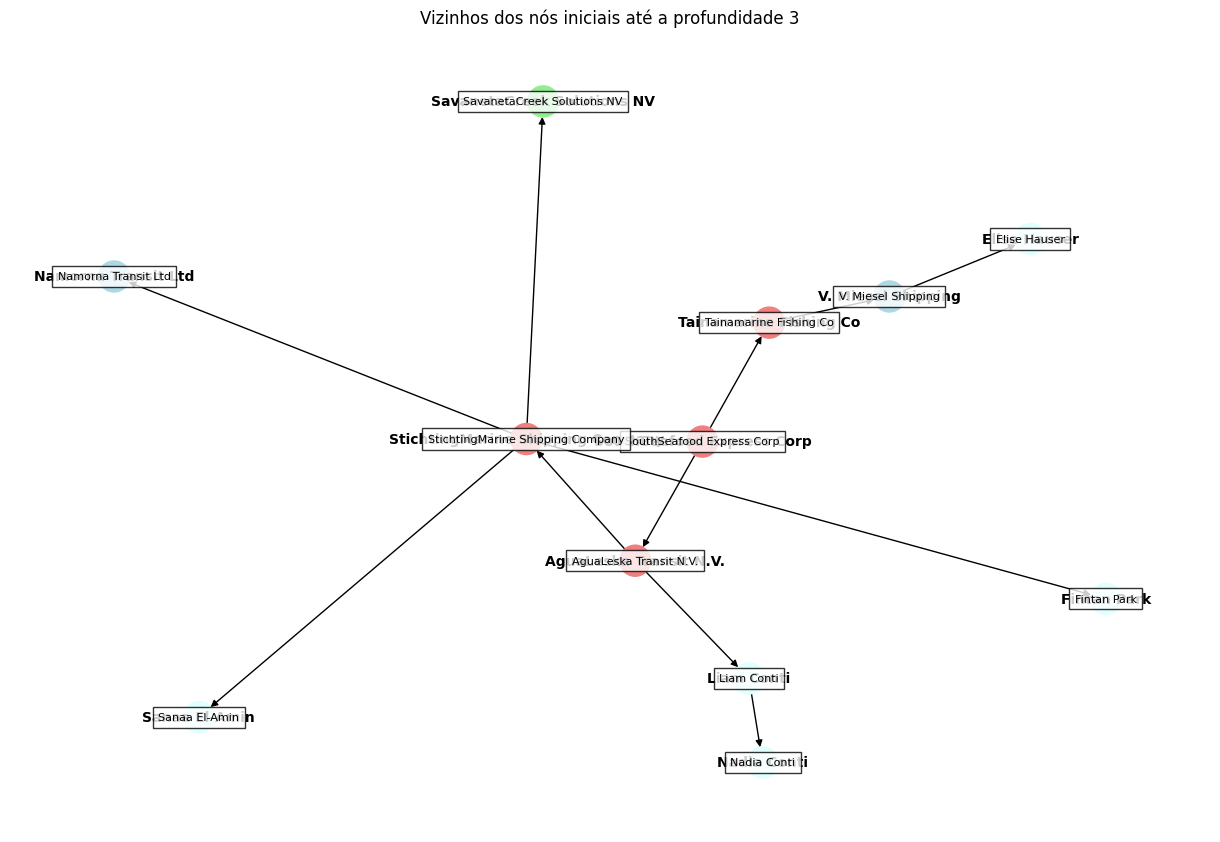

In [51]:

# Set the initial nodes
initial_nodes = [
"Joel Richards",
"Jessica Gentry",
"Carrie Hester",
"Kaylee Marshall",
"Linda Murray",
"Dawn Sanders",
"Shawn Perkins",
"Heidi Peters",
"Lawrence Lopez",
"Tyler Le"
]
initial_nodes = ["SouthSeafood Express Corp"]

depth = 3  # Define a profundidade desejada

# Create a subgraph by iteratively adding neighbors
subgraph = nx.DiGraph()

# Adicionando os nós iniciais ao subgrafo
for node in initial_nodes:
    node_type = next((n['type'] for n in data['nodes'] if n['id'] == node), None)
    subgraph.add_node(node, type=node_type)

# Explorando vizinhos até a profundidade especificada
nodes_to_explore = [(node, 0) for node in initial_nodes]

while nodes_to_explore:
    node, node_depth = nodes_to_explore.pop(0)  # Obter o próximo nó para explorar
    if node_depth < depth:
        neighbors = list(G.neighbors(node)) + list(G.predecessors(node))  # Obter vizinhos e predecessores
        for neighbor in neighbors:
            if neighbor not in subgraph.nodes:
                node_type = next((n['type'] for n in data['nodes'] if n['id'] == neighbor), None)
                subgraph.add_node(neighbor, type=node_type)  # Adicionar nó com seu tipo
                subgraph.add_edge(node, neighbor)
                nodes_to_explore.append((neighbor, node_depth + 1))

# Mapeamento de cores com base no tipo de nó
color_mapping = {
    'Entity.Organization.Company': 'lightblue',
    'Entity.Organization.LogisticsCompany': 'lightgreen',
    'Entity.Organization.FishingCompany': 'lightcoral',
    'Entity.Organization.FinancialCompany': 'lightyellow',
    'Entity.Organization.NewsCompany': 'lightpink',
    'Entity.Organization.NGO': 'lightgrey',
    'Entity.Person': 'lightcyan',
    'Entity.Person.CEO': 'lightorange'
}

# Desenhar o subgrafo com cores de nós com base no tipo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)  # Layout para os nós
node_colors = [color_mapping[subgraph.nodes[node]['type']] for node in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_weight='bold')

# Adicionar tooltips para cada nó
tooltips = {node: f"{node}: {next((n for n in data['nodes'] if n['id'] == node), None)}" for node in subgraph.nodes}

# Adicionar tooltips
for node, (x, y) in pos.items():
    plt.text(x, y, node, bbox=dict(facecolor='white', alpha=0.8), fontsize=8, ha='center', va='center')

plt.title(f"Vizinhos dos nós iniciais até a profundidade {depth}")
plt.show()

In [52]:
G = nx.node_link_graph(data)

# Lista de nós para verificar conexão com "SouthSeafood Express Corp"
nodes_to_check = [
"Joel Richards",
"Jessica Gentry",
"Carrie Hester",
"Kaylee Marshall",
"Linda Murray",
"Dawn Sanders",
"Shawn Perkins",
"Heidi Peters",
"Lawrence Lopez",
"Tyler Le"
]

# Verificar conexão com "SouthSeafood Express Corp"
for node in nodes_to_check:
    if nx.has_path(G, node, "SouthSeafood Express Corp"):
        print(f"{node} está conectado com SouthSeafood Express Corp.")

# Beneficiarios

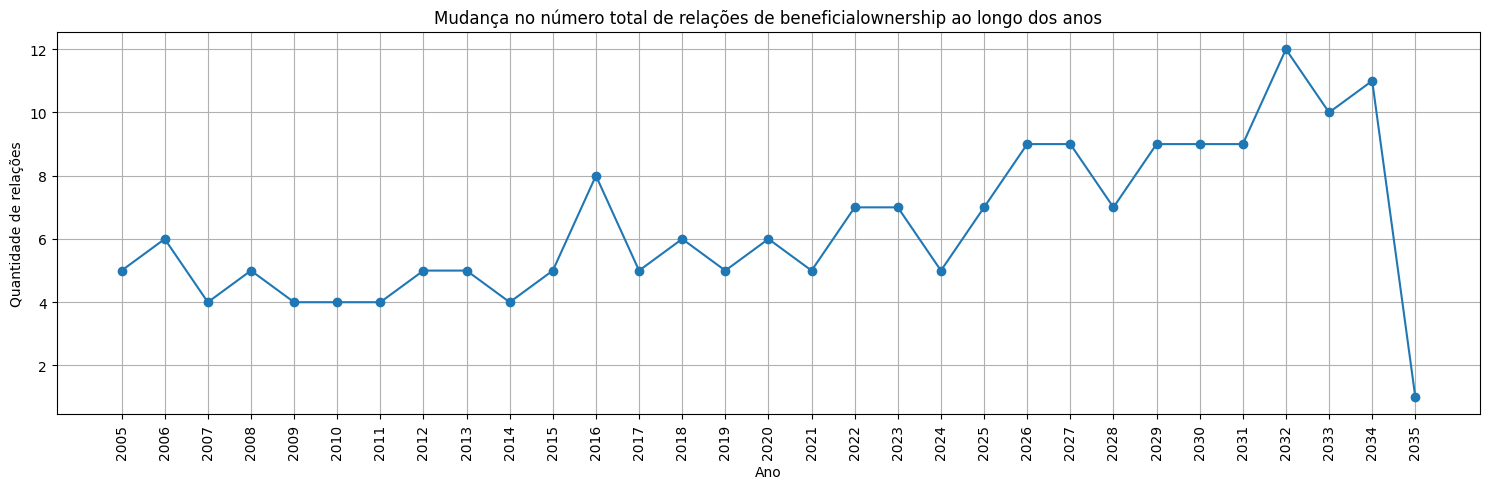

In [53]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_beneficialownership_year['start_date'], max_beneficialownership_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_beneficialownership_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
max_beneficialownership_year['count'].mean()

6.387096774193548

#  Number Works

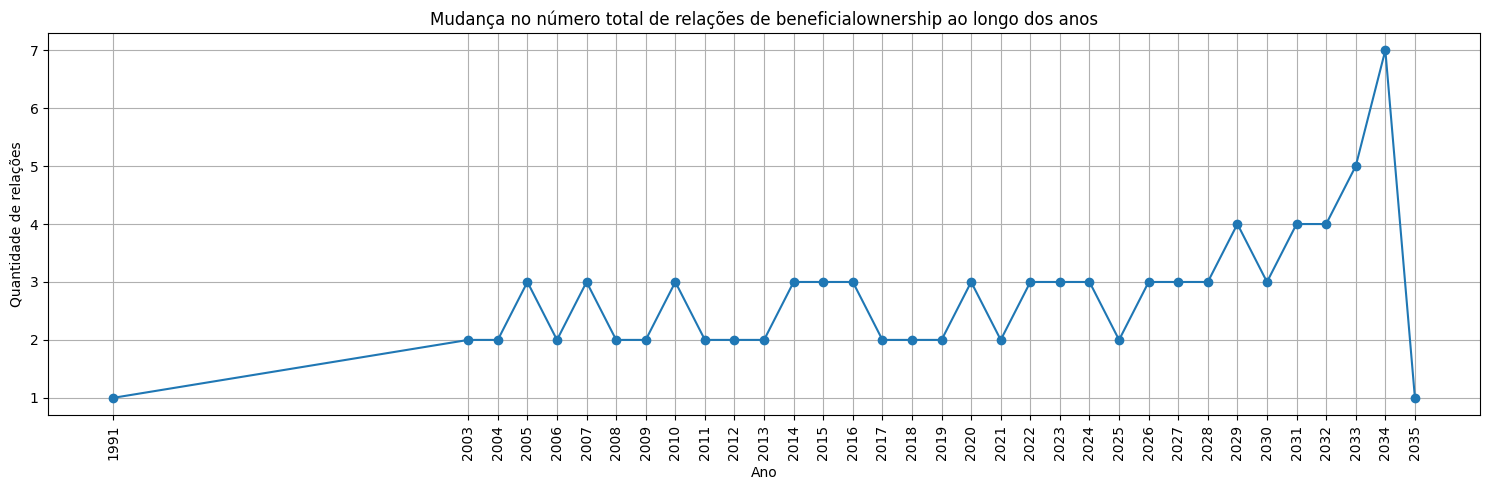

In [55]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_count_worksfor_year['start_date'], max_count_worksfor_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_count_worksfor_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(years, familyrelationship_counts, marker='o', linestyle='-', color='purple', label='Family Relationship')
plt.title('Quantidade de Family Relationship ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Relações')
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'years' is not defined

<Figure size 1200x600 with 0 Axes>

* Event.Owns.Shareholdership (Propriedade/Acionistas):

Esta relação indica que uma entidade (por exemplo, uma empresa) possui participação acionária em outra entidade. É útil para entender a estrutura de propriedade e as conexões acionárias entre empresas.

* Event.Owns.BeneficialOwnership (Propriedade Beneficiária):

Este tipo de relação se refere à propriedade beneficiária, que é diferente da propriedade legal direta. Indica que uma entidade possui benefício econômico de uma propriedade, mesmo que não seja o proprietário legal registrado. É comumente usado para identificar quem realmente se beneficia das ações ou propriedades de uma empresa, especialmente em estruturas complexas de propriedade.

* Event.WorksFor (Trabalha Para):

Esta relação indica que uma pessoa ou entidade trabalha para outra. Por exemplo, um funcionário trabalha para uma empresa. É útil para entender a estrutura organizacional e as relações de emprego dentro das entidades.

* Relationship.FamilyRelationship (Relacionamento Familiar):

Este tipo de relação indica um relacionamento familiar entre entidades. Pode ser usado para identificar conexões familiares dentro de empresas ou entre entidades, o que pode influenciar decisões empresariais e estratégias.

# 3 Desenvolva uma abordagem visual para examinar inferências. Inferir como a influência de uma empresa muda ao longo do tempo. Você pode inferir a propriedade ou influência que uma rede pode ter?

. Inferência de influência e mudanças ao longo do tempo
Abordagem Visual para Inferências:

Centralidade no Grafo: Utilize métricas de centralidade (ex. centralidade de grau, centralidade de intermediação) para identificar as empresas e pessoas mais influentes na rede ao longo do tempo.
Mapeamento Temporal de Influência: Crie um gráfico de linha para visualizar como a influência (medida pela centralidade) de uma empresa muda ao longo do tempo.
Análise de Sub-redes: Examine sub-redes específicas para entender a dinâmica de influência dentro de certos grupos ou setores.

In [ ]:
df_centralidade = pd.read_csv('centrality_new.csv')
df_centralidade.head()

,period,node,eigenvector,degree,betweenness
0,1945-03,Coleman-Lindsey,0.333333,0.0,0.0
1,1945-03,Davis-Ramsey,0.333333,0.0,0.0
2,1945-03,Henderson LLC,0.333333,0.0,0.0
3,1945-03,Hernandez Group,0.333333,0.0,0.0
4,1945-03,Howell LLC,0.333333,0.0,0.0


Grafos Temporais
Vamos criar um grafo temporal, mostrando a centralidade de intermediação (betweenness centrality) ao longo do tempo para diferentes nós.

In [ ]:
# Extraindo os anos dos períodos
df_centralidade['year'] = df_centralidade['period'].apply(lambda x: int(x.split('-')[0]))

# Criar o grafo
G = nx.DiGraph()

# Adicionar nós e arestas com marcas temporais
for _, row in df_centralidade.iterrows():
    G.add_node(row['node'], period=row['period'])
    # Aqui estamos assumindo que os nós têm alguma conexão, ajuste conforme seus dados reais
    for other_node in df_centralidade['node']:
        if other_node != row['node']:
            G.add_edge(row['node'], other_node, period=row['period'])

# Calcular a centralidade de intermediação ao longo do tempo
betweenness_over_time = df_centralidade.groupby(['year', 'node'])['betweenness'].mean().reset_index()

# Plotar a centralidade de intermediação ao longo do tempo
plt.figure(figsize=(12, 6))
for node in df_centralidade['node'].unique():
    node_data = betweenness_over_time[betweenness_over_time['node'] == node]
    plt.plot(node_data['year'], node_data['betweenness'], label=node)

plt.title('Centralidade de Intermediação ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Centralidade de Intermediação')
plt.legend()
plt.grid(True)
plt.show()

2. Heatmap Temporal
Um heatmap pode ser usado para visualizar a influência das empresas ao longo do tempo.

In [ ]:
df_centralidade

,period,node,eigenvector,degree,betweenness,year
0,1945-03,Coleman-Lindsey,3.333333e-01,0.000000,0.0,1945
1,1945-03,Davis-Ramsey,3.333333e-01,0.000000,0.0,1945
2,1945-03,Henderson LLC,3.333333e-01,0.000000,0.0,1945
3,1945-03,Hernandez Group,3.333333e-01,0.000000,0.0,1945
4,1945-03,Howell LLC,3.333333e-01,0.000000,0.0,1945
...,...,...,...,...,...,...
2230079,2035-09,Braydon Mccarthy,4.355468e-08,0.000033,0.0,2035
2230080,2035-09,Lauren Wagner,4.355468e-08,0.000017,0.0,2035
2230081,2035-09,Emily Yates,4.355468e-08,0.000017,0.0,2035
2230082,2035-09,Patrick Mueller,4.355468e-08,0.000017,0.0,2035


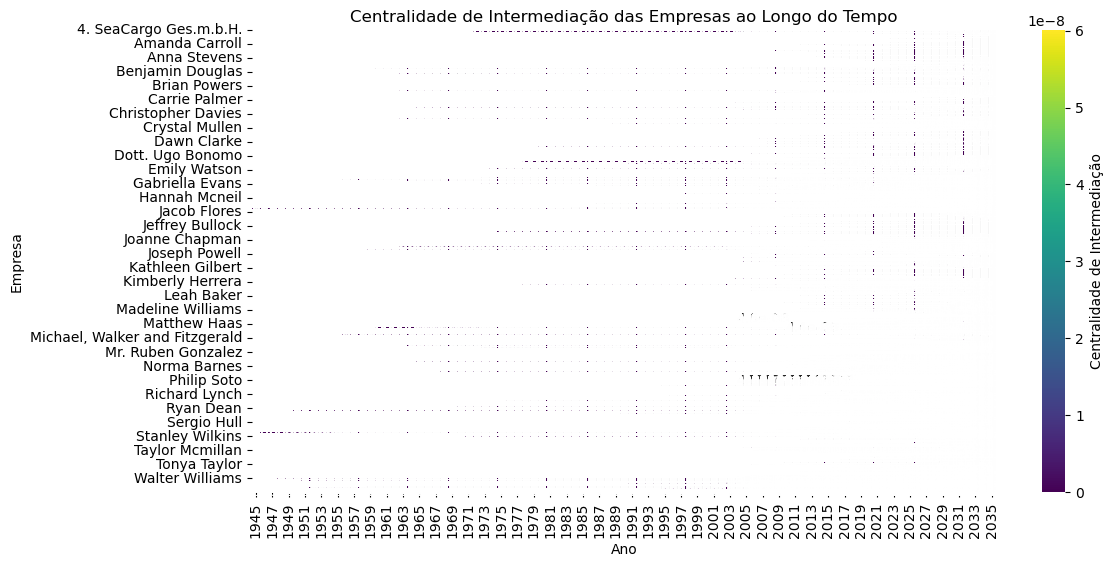

In [ ]:
# Extraindo os anos dos períodos
df_centralidade['year'] = df_centralidade['period'].apply(lambda x: int(x.split('-')[0]))

# Selecionar apenas colunas numéricas
numeric_cols = ['eigenvector', 'degree', 'betweenness']

# Agregar os dados para remover duplicatas
agg_centralidade = df_centralidade.groupby(['node', 'year'])[numeric_cols].mean().reset_index()

# Preparar os dados para o heatmap
heatmap_data = agg_centralidade.pivot(index="node", columns="year", values="betweenness")

# Plotar o heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Centralidade de Intermediação'})

plt.title('Centralidade de Intermediação das Empresas ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Empresa')
plt.show()

3. Linha do Tempo com Propriedades
Podemos criar uma linha do tempo que mostra eventos importantes, como aquisições.

In [ ]:
# Exemplo de dados de aquisições
timeline_data = [
    {'year': 1945, 'event': 'Coleman-Lindsey adquiriu Hernandez Group'},
    {'year': 1945, 'event': 'Davis-Ramsey adquiriu Henderson LLC'}
]

df_timeline = pd.DataFrame(timeline_data)

# Plotar a linha do tempo
plt.figure(figsize=(12, 6))
for index, row in df_timeline.iterrows():
    plt.plot([row['year'], row['year']], [0, 1], marker='o')
    plt.text(row['year'], 1.1, row['event'], rotation=45, ha='right')

plt.title('Linha do Tempo de Aquisições')
plt.xlabel('Ano')
plt.ylim(0, 2)
plt.grid(True)
plt.show()
